1. ensure dependencies

In [1]:
import sys
import os
from pathlib import Path

current_dir=str(Path(os.getcwd()).parent.parent)
print(f"Current dir: {current_dir}")
sys.path.insert(0, current_dir)

Current dir: d:\Programming\Python\comfyui-image-scorer


2. main train

In [2]:
import numpy as np
from step03training.full_data.data_utils import (
    load_training_data,
    filter_unused_features,
    add_interaction_features,
    load_training_scores,
)

from shared.paths import vectors_file, scores_file, filtered_data

print("--- Step 1: Loading Data ---")
if not os.path.exists(filtered_data):
    x, y = load_training_data(vectors_file, scores_file)
else:
    x = np.array([])
    y = load_training_scores(scores_file)


print(f"Loaded Data Shape: {x.shape}")

print("\n--- Step 2: Filtering Unused Features ---")
# Removes features with zero variance or zero importance in a quick probe
x, kept_indices = filter_unused_features(x, y)
print(f"Filtered Data Shape: {x.shape}")

print("\n--- Step 3: Generating Interaction Features ---")
# Adds top 500 polynomial interactions (feature_A * feature_B)
x, _ = add_interaction_features(x, y, target_k=200)
print(f"Final Data Shape (with Interactions): {x.shape}")
print("Data Preparation Complete.")

prepare_dir: D:\Programming\Python\comfyui-image-scorer\step02prepare
--- Step 1: Loading Data ---
Loaded Data Shape: (0,)

--- Step 2: Filtering Unused Features ---
Filtering features... Initial shape: (0,)
Loading filtered data from cache: D:\Programming\Python\comfyui-image-scorer\step03training\output\filtered_data.npz
Filtered Data Shape: (8090, 1354)

--- Step 3: Generating Interaction Features ---
Loading interaction data from cache: D:\Programming\Python\comfyui-image-scorer\step03training\output\interaction_data.npz
Final Data Shape (with Interactions): (8090, 1554)
Data Preparation Complete.


Training LightGBM: 100%|██████████| 1620/1620 [01:00<00:00, 26.96it/s]


Saved joblib model to: D:\Programming\Python\comfyui-image-scorer\step03training\output\model.npz.joblib
Saved ONNX model to: D:\Programming\Python\comfyui-image-scorer\step03training\output\model.npz.onnx
Training complete. Evaluation metrics:
  r2: 0.3949
  mae: 0.8421
  mse: 1.1052
  rmse: 1.0513
  model_type: LGBMRegressor
  training_time: 60.0845
  n_iter: 1609.0000
  target_transform_lambdas: [0.67028741]
  target_transform_mean: [2.08689743]
  target_transform_scale: [0.88265435]
  loss_curve: [np.float64(1.0056164214834145), np.float64(1.0023957608457699), np.float64(0.999009653787731), np.float64(0.9957418181527257), np.float64(0.9923002363971603), np.float64(0.9892180281844581), np.float64(0.9861073771327872), np.float64(0.9832294888722556), np.float64(0.9801416316437064), np.float64(0.9769450495635218), np.float64(0.9737855491419555), np.float64(0.9704451556839097), np.float64(0.967470820634893), np.float64(0.9646363261642538), np.float64(0.9618179044737811), np.float64(0.95

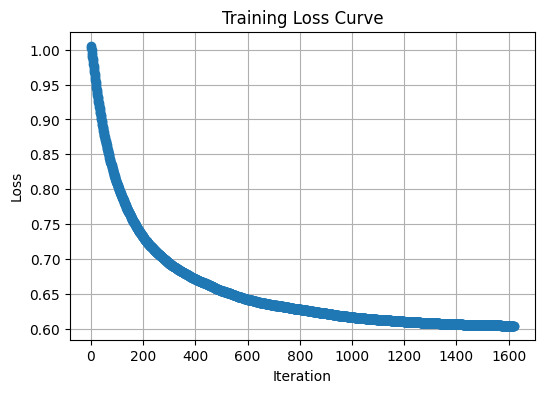

In [3]:

import json
# Force reload config to pick up file changes
from shared.config import config

import step03training.full_data.run as tr

from step03training.full_data.model_io import save_model


import numpy as np

from shared.paths import training_model

training_cfg = config["training"]
training_out = training_cfg["output_dir"]

config_selection = "top"

current_config = training_cfg[config_selection]

model, metrics = tr.train_model(
    config_dict=current_config,
    X=x,
    y=y,
    kept_features=kept_indices,
)

score = float(metrics["r2"])
training_time = float(metrics["training_time"])
new_config = {
    **current_config,
    "best_score": score,
    "training_time": training_time,
}
config["training"][config_selection].update(new_config)

save_model(model, training_model, additional_data=metrics)

# Print metrics like run_training did
print("Training complete. Evaluation metrics:")
for k, v in metrics.items():
    try:
        print(f"  {k}: {v:.4f}")
    except Exception:
        print("  {}: {}".format(k, v))

# Friendly post-training suggestion when no diagnostics available
if not metrics.get("has_loss_curve") and not metrics.get("has_n_iter"):
    print(
        "Warning: No training iterations or loss curve were recorded. Consider increasing 'epochs' or using solver='adam' with verbose=True to collect diagnostics."
    )

# Plot loss curve if available
try:
    tr.plot_loss_curve(training_model, metrics)
except Exception as e:
    print("Could not plot loss curve:", e)


In [ ]:

data = np.load(training_model, allow_pickle=True)
print("Saved model diagnostics keys:", list(data.keys()))
if "params" in data:
    raw = data["params"]
    try:
        import numpy as _np

        if isinstance(raw, _np.ndarray) and raw.shape == ():
            raw = raw.item()
    except Exception:
        pass
    if isinstance(raw, bytes):
        raw = raw.decode("utf-8")
    if isinstance(raw, str):
        try:
            params = json.loads(raw)
        except Exception:
            try:
                params = eval(raw)
            except Exception:
                params = raw
    else:
        params = raw
    print("  saved params:", params)
   # Metrics/loss info may be stored under 'metrics' or top-level keys

metrics_blob = None
if "metrics" in data:
    metrics_blob = data["metrics"]
    try:
        import numpy as _np

        if isinstance(metrics_blob, _np.ndarray) and metrics_blob.shape == ():
            metrics_blob = metrics_blob.item()
    except Exception:
        pass
if (
    metrics_blob is not None
    and isinstance(metrics_blob, dict)
    and "loss_curve" in metrics_blob
):
    lc = np.asarray(metrics_blob["loss_curve"])
    if lc.size > 0:
        print("  loss_curve (first 10):", lc[:10])
    else:
        print("  loss_curve present but empty")
elif "loss_curve" in data:
    lc = np.asarray(data["loss_curve"])
    if lc.size > 0:
        print("  loss_curve (first 10):", lc[:10])

if (
    metrics_blob is not None
    and isinstance(metrics_blob, dict)
    and "n_iter" in metrics_blob
):
    print("  saved n_iter:", int(metrics_blob["n_iter"]))
elif "n_iter" in data:
    print("  saved n_iter:", int(data["n_iter"]))


Saved model diagnostics keys: ['r2', 'mae', 'mse', 'rmse', 'model_type', 'training_time', 'n_iter', 'target_transform_lambdas', 'target_transform_mean', 'target_transform_scale', 'loss_curve', 'loss_curve_length', 'has_loss_curve', 'has_n_iter']
  loss_curve (first 10): [1.00561642 1.00239576 0.99900965 0.99574182 0.99230024 0.98921803
 0.98610738 0.98322949 0.98014163 0.97694505]
  saved n_iter: 1609


3. compare with real data

In [5]:
# DO NOT DELETE THESE LINES
# This cell compares the trained model vs data and produces a scatter plot.

from step03training.full_data.run import compare_model_vs_data
compare_model_vs_data(training_model, x,y)
 

Loading trained model from: D:\Programming\Python\comfyui-image-scorer\step03training\output\model.npz


UnpicklingError: persistent IDs in protocol 0 must be ASCII strings